# Ibuprofen

Ibuprofen is a factor investing strategy with Machine Learning.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", color_codes=True)
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

In [2]:
# read backtest data
backtest_data=pd.read_parquet("../data/backtest-0.1.1.parquet")
# select stocks with market cap > 1 million, trading price > 5 as stock universe
computed_data = pd.read_parquet("../data/computed-0.1.1.parquet")
gvkeys = computed_data[(computed_data.mcap > 1e6) & (computed_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = computed_data.loc[gvkeys]

## Hydroxyibuprofen 
Hydroxyibuprofen use a subset of factors, which are purely fundamental factors.

In [26]:
def hydroxyibuprofen(df):
    df.eval(
        """
        intangible_rdm=xrd / mcap
        market_dyr=dvc * 10 ** 6 / cshoc / prccd
        market_pe=mcap / (nicon * 10 ** 6)
        market_pch=mcap / (oancf * 10 ** 6)
        market_ps=mcap / (revt * 10 ** 6)
        market_mb=mcap / (ceq * 10 ** 6)
        market_evs=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (revt * 10 ** 6)
        market_eveda=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebitda * 10 ** 6)
        market_eve=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebit * 10 ** 6)
        market_evedacpx=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((ebitda - capx) * 10 ** 6)
        market_evocf=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((oancf) * 10 ** 6)
        """,
        inplace=True,
    )
    return df.loc[(df.mcap > 1e6) & (df.prccd > 5),:].drop(columns=["country", "sic", "cshoc", "act", "att", "ap", "capx", "ceq", "ch", "che", "chee", "cogs", "dlc", "dltis", "dltr", "dltt", "dp", "dv", "dvc", "dvt", "dlcch", "ebit", "ebitda", "fincf", "gdwl", "icapt", "intan", "invt", "ivaeq", "ivao", "ivncf", "ivst", "lct", "ltt", "mib", "nicon", "oancf", "pi", "ppegt", "ppent", "pstk", "prstkc", "rect", "revt", "seq", "sstk", "teq", "txp", "xint", "xrd", "xsga", "prccd", "cshoc", "open", "high", "low", "close", "volume"])

In [27]:
features = build_features(universe, hydroxyibuprofen, scale="rank")

In [28]:
labels = build_labels(universe, months=3, relative=True)

In [29]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2011-12-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.65      0.59      0.62     29716
           0       0.67      0.01      0.03      5107
           1       0.61      0.75      0.68     32194

    accuracy                           0.63     67017
   macro avg       0.64      0.45      0.44     67017
weighted avg       0.63      0.63      0.60     67017

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.21      0.50      0.29      9740
           0       1.00      0.00      0.00     37957
           1       0.21      0.66      0.32     11547

    accuracy                           0.21     59244
   macro avg       0.47      0.39      0.21     59244
weighted avg       0.72      0.21      0.11     59244



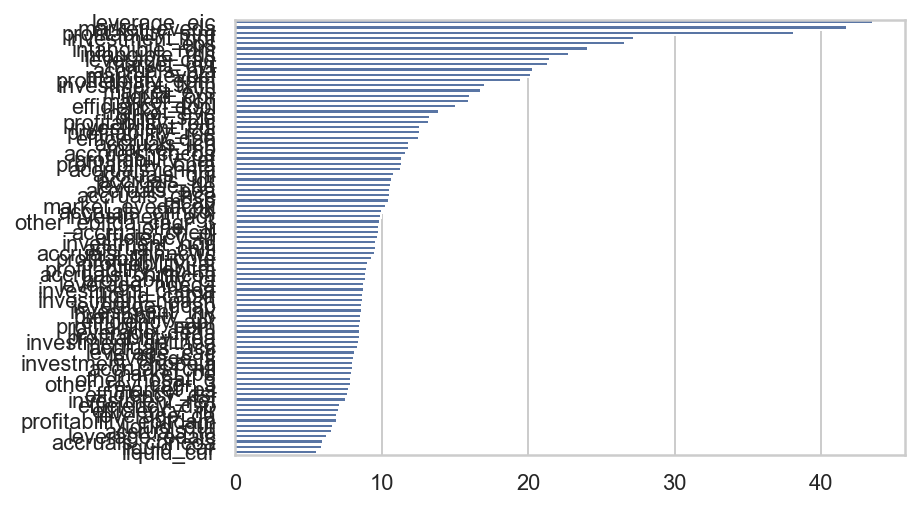

In [37]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only Sharpe Ratio: -0.11067594528126652
Short Long Sharpe Ratio: 0.5025520259816308
Long Only Sharpe Ratio: 1.1211619444808552


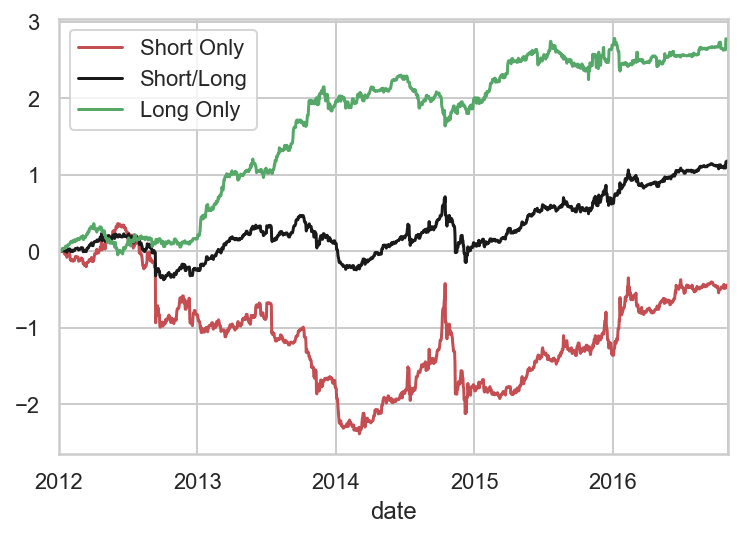

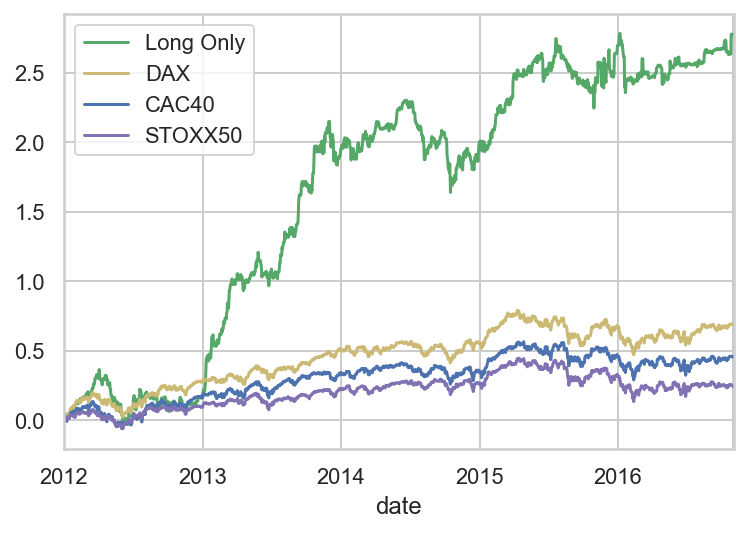

In [38]:
backtest_report(
    backtest_data,
    features,
    xgb_clf,
    test_start="2011-12-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal",
    method="percent")

## Ibuprofen

In [39]:
def ibuprofen(df):
    df.eval(
        """
        intangible_rdm=xrd / mcap
        market_dyr=dvc * 10 ** 6 / cshoc / prccd
        market_pe=mcap / (nicon * 10 ** 6)
        market_pch=mcap / (oancf * 10 ** 6)
        market_ps=mcap / (revt * 10 ** 6)
        market_mb=mcap / (ceq * 10 ** 6)
        market_evs=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (revt * 10 ** 6)
        market_eveda=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebitda * 10 ** 6)
        market_eve=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebit * 10 ** 6)
        market_evedacpx=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((ebitda - capx) * 10 ** 6)
        market_evocf=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((oancf) * 10 ** 6)
        """,
        inplace=True,
    )
    firm_factor = lambda df: df.assign(
        market_peg=(df.prccd / ((df.nicon * 10 ** 6) / df.cshoc)) / ((((df.nicon * 10 ** 6) / df.cshoc)/ (((df.nicon * 10 ** 6) / df.cshoc).shift(1))) - 1),
        hign_52w=1 - df.close/df.close.rolling(12).max(),
        mom_12m=df.close.shift(1)/df.close.shift(12) - 1,
        mom_6m=df.close.shift(1)/df.close.shift(6) - 1,
        mom_1m=df.close / df.close.shift(1) - 1,
        vol_12m=df.close.rolling(12).std(),
        vol_6m=df.close.rolling(6).std(),
        vol_3m=df.close.rolling(3).std(),
        )
    industry_factor=lambda df: df.assign(
        ind_mom_12m=df.mom_12m.mean(),
        ind_mom_6m=df.mom_6m.mean(),
        ind_mom_1m=df.mom_1m.mean(),
    )
    df = df.groupby(["gvkey"]).apply(firm_factor)
    df = df.groupby(["date", "sic"]).apply(industry_factor)
    return df.loc[(df.mcap > 1e6) & (df.prccd > 5),:].drop(columns=["country", "sic", "cshoc", "act", "att", "ap", "capx", "ceq", "ch", "che", "chee", "cogs", "dlc", "dltis", "dltr", "dltt", "dp", "dv", "dvc", "dvt", "dlcch", "ebit", "ebitda", "fincf", "gdwl", "icapt", "intan", "invt", "ivaeq", "ivao", "ivncf", "ivst", "lct", "ltt", "mib", "nicon", "oancf", "pi", "ppegt", "ppent", "pstk", "prstkc", "rect", "revt", "seq", "sstk", "teq", "txp", "xint", "xrd", "xsga", "prccd", "cshoc", "open", "high", "low", "close", "volume"])

In [40]:
features = build_features(universe, ibuprofen, scale="rank")

In [41]:
labels = build_labels(universe, months=3, relative=True)

In [42]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2011-12-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.64      0.61      0.63     29716
           0       0.59      0.02      0.04      5107
           1       0.62      0.74      0.68     32194

    accuracy                           0.63     67017
   macro avg       0.62      0.46      0.45     67017
weighted avg       0.63      0.63      0.61     67017

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.22      0.53      0.31      9740
           0       0.86      0.00      0.00     37957
           1       0.21      0.66      0.32     11547

    accuracy                           0.22     59244
   macro avg       0.43      0.40      0.21     59244
weighted avg       0.63      0.22      0.11     59244



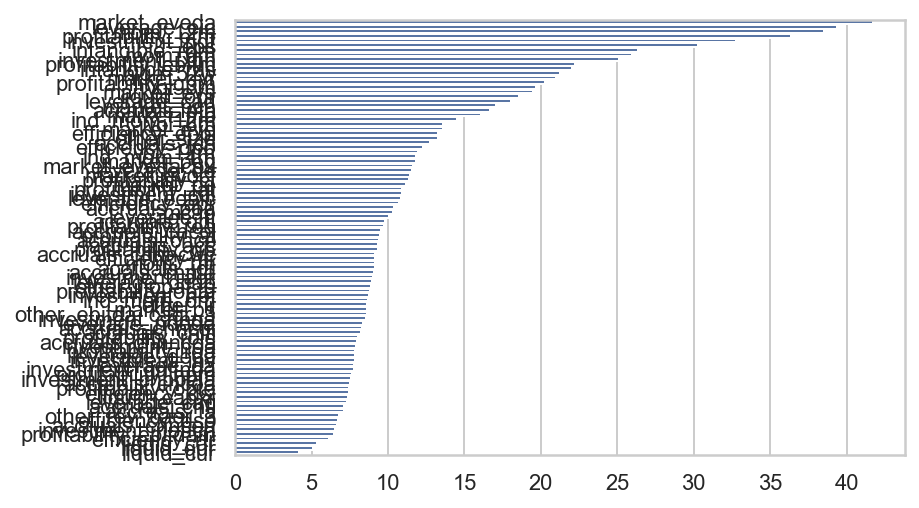

In [43]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only Sharpe Ratio: -0.13832355274701424
Short Long Sharpe Ratio: 1.4113832458330424
Long Only Sharpe Ratio: 2.542471523241857


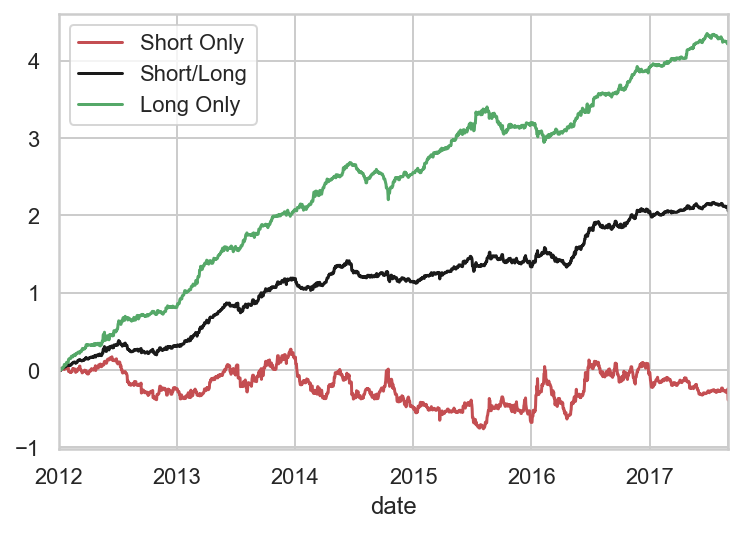

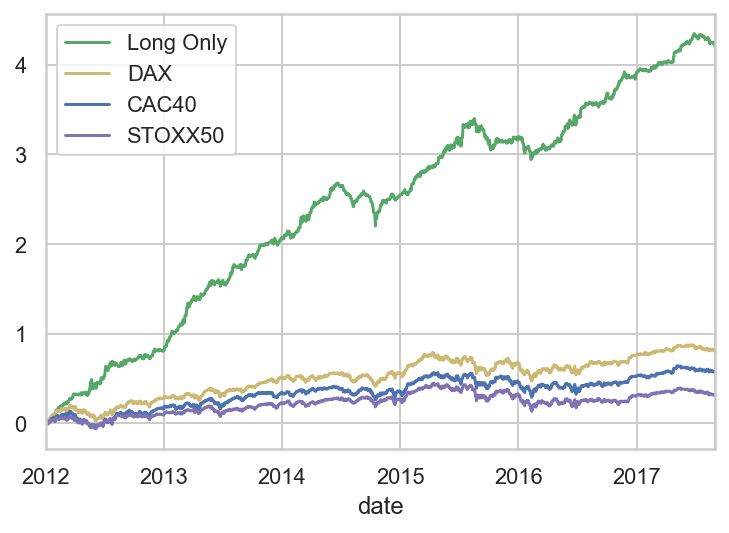

In [46]:
backtest_report(
    backtest_data,
    features,
    xgb_clf,
    test_start="2011-12-01",
    test_end="2016-01-01",
    months=3,
    n=20,
    weight="equal",
    method="percent")